# Assignmnet 2 (100 points)

**Name:** Jiahui Dai<br>
**Email:** jid4620@thi.de<br>
**Group:** B <br>
**Hours spend *(optional)* :** <br>

In [ ]:
import math
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter, OrderedDict
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

In [2]:
##############################
### To load stopwords
### Generated from ChatGPTmm
##############################

import ssl
import certifi
import urllib.request
import nltk

# Set up SSL context using certifi
context = ssl.create_default_context(cafile=certifi.where())

# Patch urllib with the custom context for NLTK downloader
urllib.request.install_opener(urllib.request.build_opener(urllib.request.HTTPSHandler(context=context)))

# Now download the stopwords and punkt resource
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jiahuidai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jiahuidai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### SMS Spam Detection *(60 points)*

<p>You are hired as an AI expert in the development department of a telecommunications company. The first thing on your orientation plan is a small project that your boss has assigned you for the following given situation. Your supervisor has given away his private cell phone number on too many websites and is now complaining about daily spam SMS. Therefore, it is your job to write a spam detector in Python. </p>

<p>In doing so, you need to use a Naive Bayes classifier that can handle both bag-of-words (BoW) and tf-idf features as input. For the evaluation of your spam detector, an SMS collection is available as a dataset - this has yet to be suitably split into train and test data. To keep the costs as low as possible and to avoid problems with copyrights, your boss insists on a new development with Python.</p>

<p>Include a short description of the data preprocessing steps, method, experiment design, hyper-parameters, and evaluation metric. Also, document your findings, drawbacks, and potential improvements.</p>

<p>Note: You need to implement the bag-of-words (BoW) and tf-idf feature extractor from scratch. You can use existing python libraries for other tasks.</p>

**Dataset and Resources**

* SMS Spam Collection Dataset: https://archive.ics.uci.edu/dataset/228/sms+spam+collection

In [3]:
class OrderedCounter(Counter, OrderedDict):
    '''To create an ordered counter'''

    pass

In [4]:
class SpamClassifier():

    def __init__(self, mode=None):
        assert mode in ["bow", "tfidf"], "Mode must be either 'bow' or 'tfidf'"

        self.mode = mode
        self.vocab = dict() # index of vocab
        self.model = MultinomialNB()

    def preprocess(self, text: str):
        """
        To preprocess words
        1. Tokenisation
        2. Stop words removal
        3. Stemming
        """
        stop_words = stopwords.words('english')

        # Try tokenize
        try: 
            tokens = word_tokenize(text)
        except Exception as e:
            tokens = re.split(r"\W+", text)
            tokens = [word.lower() for word in tokens if len(word) > 0]

        tokens = [token for token in tokens if token not in stop_words] # remove stop words
        tokens = [PorterStemmer().stem(token) for token in tokens] # Stemming

        return tokens

    def build_vocab(self, documents):
        """
        Build vocabulary list from a list of tokenized documents
        Assign each word to an unique index = len(vocab)
        """
        vocab = dict()
        for doc in documents:
            for word in set(self.preprocess(doc)):
                if word not in vocab:
                    vocab[word] = len(vocab) # unique index

        self.vocab = vocab

    def bag_of_words(self, documents):
        """
        Converts a list of documents (input) to Bag-of-Words (BoW) feature matrix
        Each document is represented as a vector that counts how many times each unique word appear
        """
        X = [] # list of vectors for each document

        for tokens in documents:
            vector = [0] * len(self.vocab) # initialise 0-vector to the size of vocab
            word_count = OrderedCounter(tokens)

            for word, count in word_count.items():
                if word in self.vocab:
                    vector[self.vocab[word]] = count # tag count to corresponding word position on vector

            # Append current vector to master vector
            X.append(vector) 
        
        return X
    
    def tf_idf(self, documents):
        """
        Converts a list of documents (input) to TF-IDF feature matrix

        - TF (Term Frequency): How often a word appears in a document.
        - IDF (Inverse Document Frequency): How rare the word is across all documents.
        - TF-IDF(word, doc) = (Count of word in doc / Total words in doc) * log(Total docs / Docs containing the word)
        """
        N = len(documents) # Total docs

        # Document frequency: count how many words each word appear in
        doc_freq = OrderedCounter()
        for tokens in documents:
            doc_freq.update(set(tokens))

        # Inverse Document Frequency (idf)
        idf = {word: math.log(N / (doc_freq[word])) for word in doc_freq}

        # TF-IDF Vectorization
        X = []

        for tokens in documents:
            tf = OrderedCounter(tokens) # Term frequency
            vector = [0] * len(self.vocab) # initialise 0-vector to the size of vocab

            for word in tf:
                if word in self.vocab and word in idf:
                    tf_score = tf[word] / len(tokens)
                    vector[self.vocab[word]] = tf_score * idf[word] # tag count to corresponding word position on vector with tf-idf score

            # Append current vector to master vector
            X.append(vector) 

        return X
    

    def fit(self, X_train_text, y_train):
        """
        Fit training data into model based on mode selected
        """
        self.build_vocab(X_train_text)
        tokenized_docs = [self.preprocess(doc) for doc in X_train_text]

        if self.mode == 'bow':
            X_train = self.bag_of_words(tokenized_docs)
        else:
            X_train = self.tf_idf(tokenized_docs)
        
        self.model.fit(X_train, y_train)

    def transform(self, X_text):
        """
        Transform test data into vectors based on mode selected
        """
        tokenized_docs = [self.preprocess(doc) for doc in X_text]

        if self.mode == 'bow':
            return self.bag_of_words(tokenized_docs)
        else:
            return self.tf_idf(tokenized_docs)
        
    def predict(self, X_test_text):
        """
        Predict test data on model
        """
        X_test = self.transform(X_test_text)
        return self.model.predict(X_test)

    def evaluate(self, X_test_text, y_test, target_names=["ham", "spam"]):
        """
        Evaluate test data based on precision, recall, f1-score, accuracy
        """
        y_pred = self.predict(X_test_text)
        print(classification_report(y_test, y_pred, target_names=target_names))

        return classification_report(y_test, y_pred, target_names=target_names, output_dict=True)



Load dataset

In [5]:
# Load filenames
data_folder = "sms_spam_collection"
sms_spam_collection = os.path.join(data_folder, "SMSSpamCollection")

# Load dataset (SMS Spam Collection dataset)
df = pd.read_csv(sms_spam_collection, sep="\t", names=["spam", "message"])
# df = df.drop_duplicates() # remove duplicates
df['spam'] = df['spam'].map({'ham': 0, 'spam': 1})

df.head()

,spam,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df['spam'].value_counts()

spam
0    4825
1     747
Name: count, dtype: int64

Split into training and testing

In [7]:
# Split into training and testing
X_train_text, X_test_text, y_train, y_test = train_test_split(df['message'], df['spam'], test_size=0.2, random_state=42)

Bags of Words Vectorisation Model

In [8]:
bow_model = SpamClassifier(mode="bow")  # or mode="bow"
bow_model.fit(X_train_text.tolist(), y_train)
bow_report = bow_model.evaluate(X_test_text.tolist(), y_test)

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       966
        spam       0.98      0.95      0.96       149

    accuracy                           0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



TF-IDF Vectorisation Model

In [9]:
tfidf_model = SpamClassifier(mode="tfidf")
tfidf_model.fit(X_train_text.tolist(), y_train)
tfidf_report = tfidf_model.evaluate(X_test_text.tolist(), y_test)

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.97      0.88      0.92       149

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



Visualising Results

In [10]:
# Extracting metrics from the reports
def extract_metrics(report):
    precision = [report["ham"]["precision"], report["spam"]["precision"]]
    recall = [report["ham"]["recall"], report["spam"]["recall"]]
    f1_score = [report["ham"]["f1-score"], report["spam"]["f1-score"]]
    accuracy = report["accuracy"]
    return precision, recall, f1_score, accuracy

# Extract metrics for both models
bow_precision, bow_recall, bow_f1, bow_accuracy = extract_metrics(bow_report)
tfidf_precision, tfidf_recall, tfidf_f1, tfidf_accuracy = extract_metrics(tfidf_report)

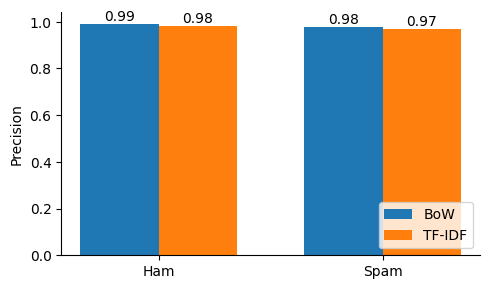

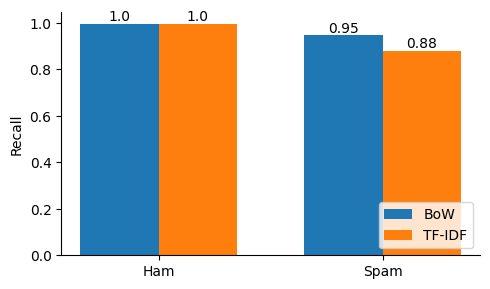

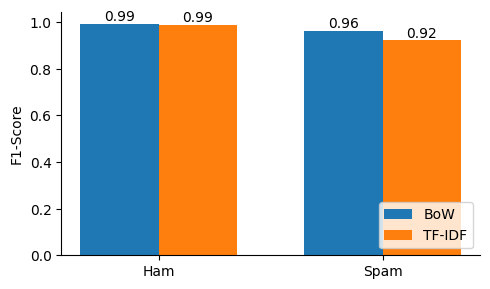

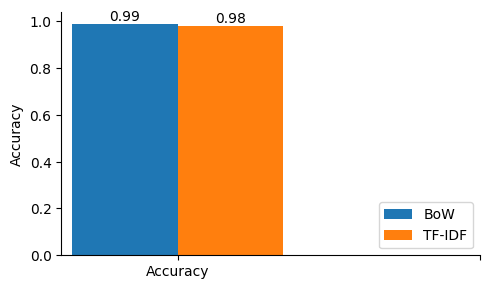

In [11]:
def plot_comparison(metric1, metric2, metric_name, labels=['Ham', 'Spam']):
    """
    Plot comparison of two metrics for Bow and TF-IDF models.

    - metric1: BoW model metric
    - metric2: TF-IDF model metric
    - metric_name
    - labels: ['Ham', 'Spam']
    """
    x = np.arange(len(labels))  # Position of the bars
    width = 0.35  # Width of bars

    fig, ax = plt.subplots(figsize=(5, 3))

    if isinstance(metric1, list) and isinstance(metric2, list):
        # Both metrics are lists (e.g., Precision, Recall, F1-Score)
        bars1 = ax.bar(x - width / 2, metric1, width, label='BoW')
        bars2 = ax.bar(x + width / 2, metric2, width, label='TF-IDF')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
    elif isinstance(metric1, float) and isinstance(metric2, float):
        # Both metrics are floats (e.g., Accuracy)
        bars1 = ax.bar(0 - width / 2, metric1, width, label='BoW')
        bars2 = ax.bar(0 + width / 2, metric2, width, label='TF-IDF')
        ax.set_xticks([0])  # Single bar position for accuracy
        ax.set_xticklabels(['Accuracy'])


    # Add the metric value on top of the bars
    for bar in bars1:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')
    
    for bar in bars2:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')


    ax.set_ylabel(metric_name)
    ax.set_xticks(x)
    ax.legend(loc='lower right')

    # Remove the top and right borders (spines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig(f'output/model_{metric_name.lower()}.png')
    plt.show()


# Plot comparisons for all metrics
plot_comparison(bow_precision, tfidf_precision, 'Precision')
plot_comparison(bow_recall, tfidf_recall, 'Recall')
plot_comparison(bow_f1, tfidf_f1, 'F1-Score')
plot_comparison(bow_accuracy, tfidf_accuracy, 'Accuracy')

 ### Search Engine *(40 points)*

Your boss is impressed with your spam detector and assigns you a new task. As part of improving internal tools, the company wants a search engine that can search through SMS messages and rank them by relevance. Implement the PageRank algorithm from scratch to score each SMS message based on its importance in the document graph.

*   Compute TF-IDF vectors for all SMS messages (you can leverage previous implementation)
*   Construct a document graph, where each node represents an SMS message and edges are the links between nodes.
*  Implement the PageRank algorithm from scratch to assign an importance score to each SMS message based on its position in the document graph.

#### Hint : You can use the previous dataset or any dataset from your choice.




Compute TF-IDF vectors for all SMS messages

In [12]:
sms_msg = df['message'].tolist()
sms_labels = df['spam'].tolist()

# Compute TF-IDF vectors
model = SpamClassifier(mode="tfidf")
model.build_vocab(sms_msg)
tokenized_docs = [model.preprocess(doc) for doc in sms_msg]
tfidf_vectors = model.tf_idf(tokenized_docs)

Construct document graph:
- node = SMS message
- edges = links between nodes

In [13]:
def dot_product(A, B):
    return np.dot(A, B)

def magnitude(A):
    return np.linalg.norm(A)

def cosine_sim(A, B):
    """
    Compute the cosine similarity between two vectors.
    """
    mag_A = magnitude(A)
    mag_B = magnitude(B)

    # Avoid division by zero
    if mag_A == 0 or mag_B == 0:
        return 0

    return dot_product(A, B) / (mag_A * mag_B)

In [14]:
def compute_similarity_matrix(tfidf_vectors):
    """
    Compute the cosine similarity matrix for TF-IDF vectors
    """
    # Convert to np.array
    tfidf_matrix = np.array(tfidf_vectors)

    # Compute cosine similarity
    dot_product_matrix = np.dot(tfidf_matrix, tfidf_matrix.T)   # Compute dot matrix with its transpose
    magnitudes = np.linalg.norm(tfidf_matrix, axis=1)           # Compute the magnitudes (norms) of each vector
    denom = np.outer(magnitudes, magnitudes)                    # Outer product of magnitudes
    epsilon = 1e-10                                             # Add epsilon to avoid division by zero
    cosine_sim_matrix = dot_product_matrix / (denom + epsilon) 

    return cosine_sim_matrix

cosine_sim_matrix = compute_similarity_matrix(tfidf_vectors)

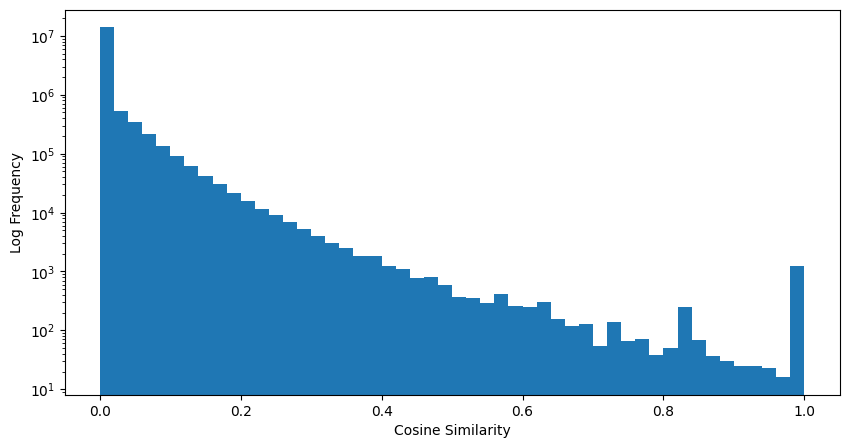

In [15]:
# Flatten the upper triangle (excluding diagonal) to avoid redundancy
upper_tri = cosine_sim_matrix[np.triu_indices_from(cosine_sim_matrix, k=1)]

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.hist(upper_tri, bins=50)
plt.yscale("log")  # 🔍 Log scale for y-axis
# plt.title('Histogram of Cosine Similarities (Log Scale)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Log Frequency')
# plt.grid(True)
plt.savefig('output/cosine-similarity-histogram')
plt.show()

In [16]:
def plot_graph(cosine_sim_matrix, labels, threshold=0.1):
    # Create an undirected graph
    N = cosine_sim_matrix.shape[0]
    G = nx.Graph()

    # Add nodes to the graph
    for i in range(N):
        G.add_node(i)

    # Add edges based on the cosine similarity threshold
    for i in range(N):
        for j in range(i + 1, N):
            if cosine_sim_matrix[i][j] > threshold:
                G.add_edge(i, j, weight=cosine_sim_matrix[i][j])

    # Color nodes based on spam/ham classification (0: ham, 1: spam)
    node_colors = ['red' if label == 1 else 'green' for label in labels]

    # Plot the graph
    pos = nx.spring_layout(G)  # Layout for nodes
    plt.figure(figsize=(12, 12))
    
    # Draw the graph
    nx.draw(
        G, 
        pos, 
        with_labels=True, 
        node_size=50, 
        node_color=node_colors,  # Colorize nodes based on spam/ham
        font_size=10, 
        font_weight='bold', 
        edge_color='gray'
    )
    
    # Title and display
    # plt.title(f"Document Similarity Graph (Spam vs Ham) - Threshold: {threshold}")
    plt.savefig(f"output/document-similarity-threshold-{threshold}.png")
    plt.show()

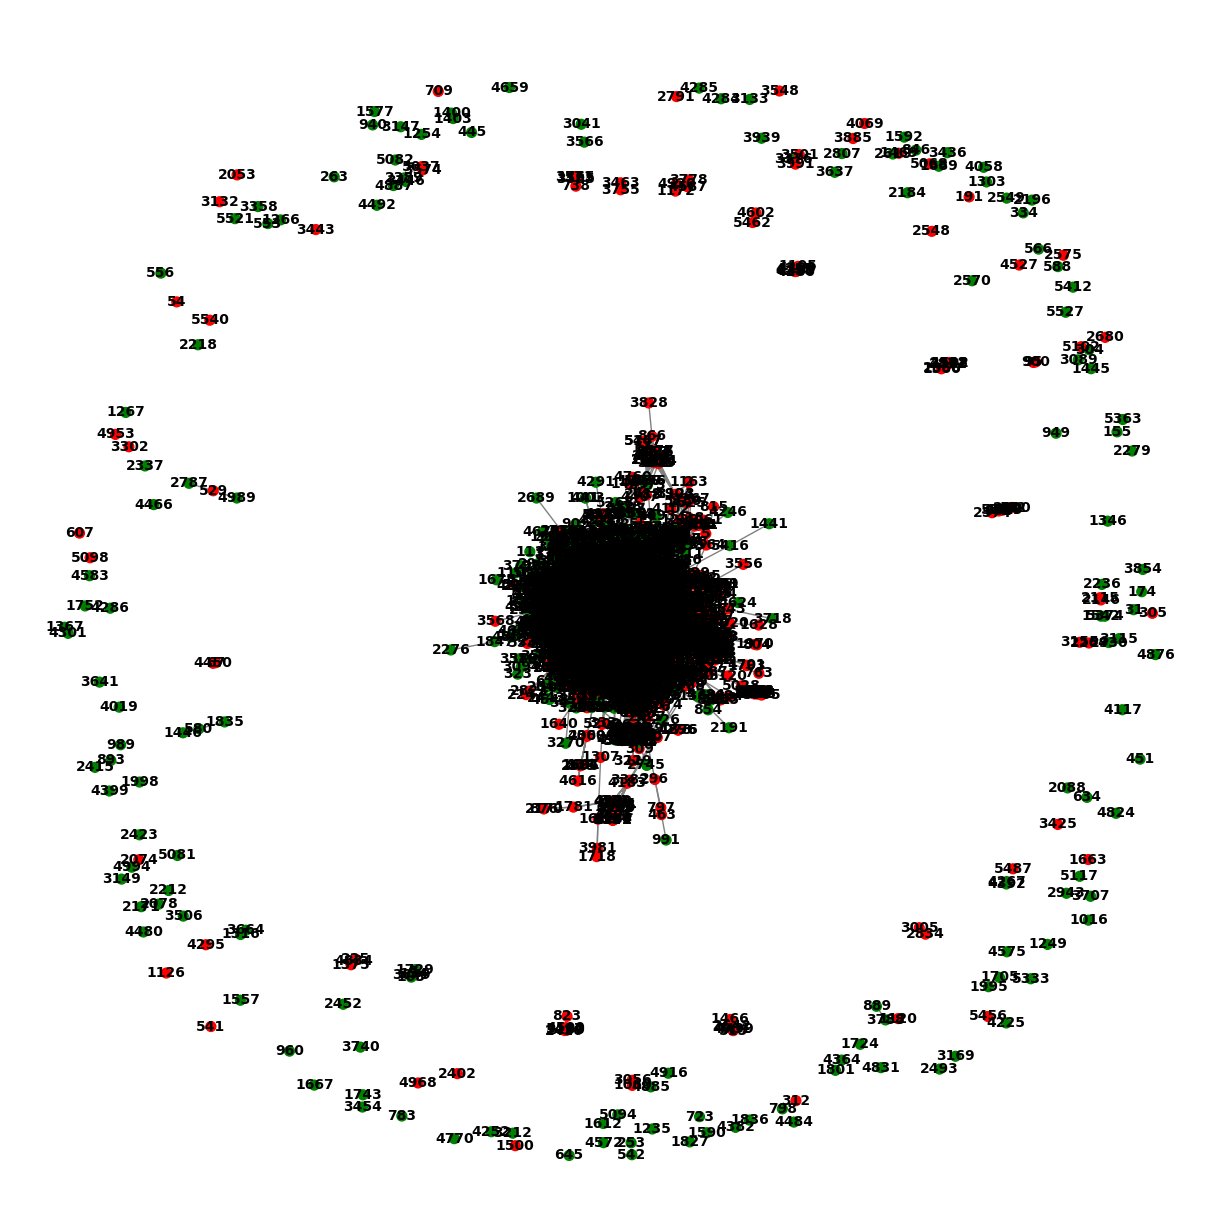

In [17]:
plot_graph(cosine_sim_matrix, sms_labels, threshold=0.2)

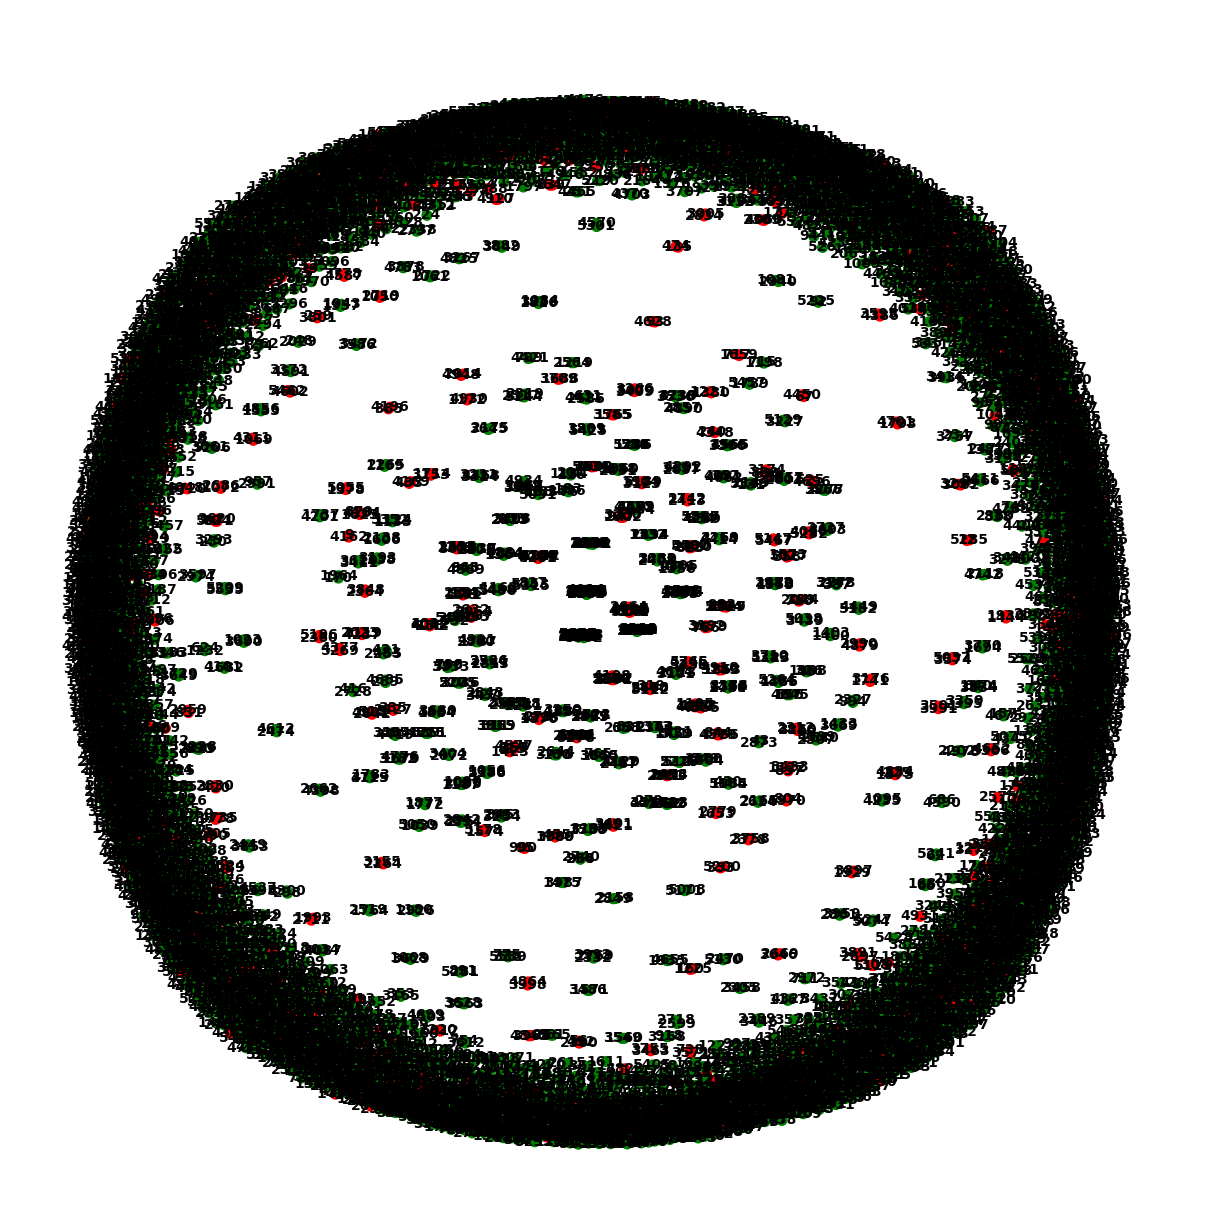

In [18]:
plot_graph(cosine_sim_matrix, sms_labels, threshold=0.8)

PageRank algorithm

In [19]:
def create_graph_matrix(cosine_sim_matrix, threshold=0.1):
    return np.where(cosine_sim_matrix > threshold, cosine_sim_matrix, 0.0)

In [20]:
def pagerank(graph, d=0.85, max_iter=100, tol=1e-6):
    N = graph.shape[0] # Total number of nodes in graph
    PR = np.ones(N) / N  # Initialize PR values

    # Out-degree (number of outgoing links) for each node
    out_degree = np.sum(graph != 0, axis=1)

    # Handle nodes with zero out-degree
    out_degree[out_degree == 0] = 1

    for _ in range(max_iter):
        # Compute the new PR vector
        # Start with the random jump factor (1 - d) / N
        new_PR = np.ones(N) * (1 - d) / N
        
        # Matrix multiplication to calculate PR contributions
        new_PR += d * graph.T.dot(PR / out_degree)

        # Check for convergence
        if np.linalg.norm(new_PR - PR, 1) < tol:
            break

        PR = new_PR


    return PR

In [21]:
graph = create_graph_matrix(cosine_sim_matrix, threshold=0.8)
pr_score = pagerank(graph)

# Rank SMS messages based on PageRank scores
ranked_messages = sorted(zip(pr_score, df['spam'], df['message']), key=lambda x: x[0], reverse=True)

# Write to CSV
ranked_df = pd.DataFrame(ranked_messages[:20], columns=["PageRank", "Label", "Message"])
ranked_df["Label"] = ranked_df["Label"].replace({1: 'Spam', 0: 'Ham'})
ranked_df.to_csv("output/ranked_sms_messages.csv", index=False, sep='\t')

bottom_df = pd.DataFrame(ranked_messages[-20:], columns=["PageRank", "Label", "Message"])
bottom_df["Label"] = bottom_df["Label"].replace({1: 'Spam', 0: 'Ham'})
bottom_df.to_csv("output/bottom_ranked_sms_messages.csv", index=False, sep='\t')

# Display top ranked messages
for i, (score, spam, message) in enumerate(ranked_messages[:20]):
    print(f"Rank {i+1}: {score:.10f} - {spam} - {message}")

Rank 1: 0.0001794688 - 0 - Beerage?
Rank 2: 0.0001794688 - 0 - 645
Rank 3: 0.0001794688 - 0 - * Will be september by then!
Rank 4: 0.0001794688 - 0 - O was not into fps then.
Rank 5: 0.0001794688 - 0 - I pocked you up there before
Rank 6: 0.0001794688 - 0 - Or just do that 6times
Rank 7: 0.0001794688 - 0 - What's the significance?
Rank 8: 0.0001794688 - 0 - Annoying isn't it.
Rank 9: 0.0001794688 - 0 - Which channel:-):-):):-).
Rank 10: 0.0001794688 - 0 - And how's your husband.
Rank 11: 0.0001794688 - 0 - S:)no competition for him.
Rank 12: 0.0001794688 - 0 - ALRITE
Rank 13: 0.0001794688 - 0 - So how's the weather over there?
Rank 14: 0.0001794688 - 0 - It'll be tough, but I'll do what I have to
Rank 15: 0.0001794688 - 0 - Then why you not responding
Rank 16: 0.0001794688 - 0 - I have no idea where you are
Rank 17: 0.0001794688 - 0 - Then we gotta do it after that
Rank 18: 0.0001794688 - 0 - What not under standing.
Rank 19: 0.0001794688 - 0 - hanks lotsly!
Rank 20: 0.0001794688 - 0 -

## You might need the follwoing formulas for your implementation

---

### 1) Cosine Similarity Between Two Document Vectors

Cosine similarity measures how similar two vectors are based on the angle between them:

$$
\text{cosine\_sim}(A, B) = \frac{A \cdot B}{\|A\| \cdot \|B\|}
$$

- \( A \cdot B \): Dot product of vectors \( A \) and \( B \)  
- \( \|A\| \): Euclidean norm (magnitude) of vector \( A \)  
- \( \|B\| \): Euclidean norm of vector \( B \)

**Use case**: Comparing TF-IDF vectors to measure similarity between two messages.

---

### 2) PageRank of a Node \( i \)

PageRank estimates the importance of a document based on its connections in a graph:

$$
PR(i) = \frac{1 - d}{N} + d \sum_{j \in M(i)} \frac{PR(j)}{L(j)}
$$

Where:
- \( PR(i) \): PageRank score of node \( i \)  
- \( d \): Damping factor (typically 0.85)  
- \( N \): Total number of nodes (documents) in the graph  
- \( M(i) \): Set of nodes that link to node \( i \)  
- \( L(j) \): Number of outbound links from node \( j \)  

**Interpretation**:  
- A document is important if **important documents link to it**.  
- The score is split among a node’s outbound links.  
- The **teleportation term** $\text(\frac{1 - d}{N})$ accounts for random jumps, ensuring stability and fairness.

---



### Additional Experiments *(5 additional points - <span style="color: red;">Optional</span>)*